# Librairies

In [1]:
! pip install scikit-learn>=0.24.2
! pip install pytest-runner
! pip install libpecos>=0.2.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_extraction, model_selection, metrics
import warnings
warnings.filterwarnings("ignore")

# Chargement des données

In [3]:
df = pd.read_csv('../input/stackoverflow-questions-tags/questions_tags_cleaned.csv')
df

,X,Y
0,convert decim c# convert decim c# use chang fo...,c# floating-point type-conversion double decimal
1,width collaps percentag width child element ab...,html css internet-explorer-7
2,calcul someon age base type birthday calcul so...,c# .net datetime
3,calcul time c# calcul time c# given datetim va...,c# datetime time
4,determin user timezon determin user timezon wa...,html browser timezone
...,...,...
49506,git submodul way work copi within work copi gi...,git
49507,sizeof bit bit data model sizeof bit bit data ...,c 64-bit sizeof
49508,use jqueri chang html tag use jqueri chang htm...,jquery
49509,differ express modifi flag differ express modi...,regex


# Modélisation
The eXtreme Multi-label Ranking (XMR) problem is defined by two matrices
* instance-to-feature matrix X, of shape N by D in SciPy CSR format
* instance-to-label matrix Y, of shape N by L in SciPy CSR format

In [4]:
def df_scores():
    import warnings
    warnings.filterwarnings("ignore")
    scores = {
        'Train': {
            'Accuracy' :  metrics.accuracy_score(Y_train, Y_pred_train),
            'Recall' :    metrics.recall_score(Y_train, Y_pred_train, average='weighted'),
            'Precision' : metrics.precision_score(Y_train, Y_pred_train, average='weighted'),
            'F1 score' :  metrics.f1_score(Y_train, Y_pred_train, average='weighted'),
            'Jaccard' :   metrics.jaccard_score(Y_train, Y_pred_train, average='weighted')},
        'Test': {
            'Accuracy' :  metrics.accuracy_score(Y_test, Y_pred_test),
            'Recall' :    metrics.recall_score(Y_test, Y_pred_test, average='weighted'),
            'Precision' : metrics.precision_score(Y_test, Y_pred_test, average='weighted'),
            'F1 score' :  metrics.f1_score(Y_test, Y_pred_test, average='weighted'),
            'Jaccard' :   metrics.jaccard_score(Y_test, Y_pred_test, average='weighted')}}
    return pd.DataFrame.from_dict(scores).T

In [5]:
tfidfX = feature_extraction.text.TfidfVectorizer()
tfidfY = feature_extraction.text.TfidfVectorizer()
X_text = df['X'].values
X = tfidfX.fit_transform(df['X'].values).astype(np.float32)
Y = tfidfY.fit_transform(df['Y'].values).astype(np.float32)
Y[Y!=0] = 1
X_text_train, X_text_test, X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_text, X, Y, test_size=0.3, random_state=37)

In [6]:
print(f"Sparsité de X : {X.count_nonzero() / X.shape[0] / X.shape[1] *100:.3f}% ; Dimensions {X.shape}")
print(f"Sparsité de Y : {Y.count_nonzero() / Y.shape[0] / Y.shape[1] *100:.3f}% ; Dimensions {Y.shape}")

Sparsité de X : 0.365% ; Dimensions (49511, 8556)
Sparsité de Y : 0.205% ; Dimensions (49511, 1395)


## XR-Linear

In [7]:
%%time
from pecos.xmc.xlinear.model import XLinearModel
# label_feat = LabelEmbeddingFactory.create(Y_train, X_train)
# cluster_chain = Indexer.gen(label_feat)
xlm = XLinearModel.train(X_train, Y_train)  # , C=cluster_chain)
xlm.save("XR-Linear")
xlm = XLinearModel.load("XR-Linear", is_predict_only=False)

CPU times: user 1min 40s, sys: 88 ms, total: 1min 41s
Wall time: 25.9 s


In [8]:
%%time
tmp1 = xlm.predict(X_train)
tmp2 = xlm.predict(X_test)

CPU times: user 2min 55s, sys: 3.03 s, total: 2min 58s
Wall time: 49.8 s


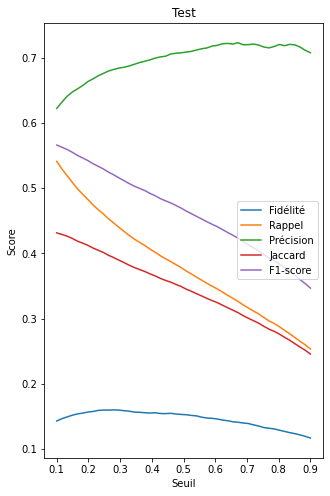

In [9]:
# Différents scores en fonction du seuil de validation de tag
rangeX = np.linspace(0.1,0.9,50)
plt.figure(figsize=(5,8))
for score, kwargs, title in zip(
    [metrics.accuracy_score, metrics.recall_score, metrics.precision_score, metrics.jaccard_score, metrics.f1_score], 
    [{},{'average':'weighted'},{'average':'weighted'},{'average':'weighted'},{'average':'weighted'}],
    ['Fidélité','Rappel','Précision','Jaccard','F1-score']):
    
    scores_train, scores_test = [], []
    for threshold in rangeX:
        scores_test.append(score(Y_test, tmp2 > threshold, **kwargs))
    plt.plot(rangeX, scores_test, label=title)
    
plt.title('Test')
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.legend()
plt.show()

In [10]:
threshold = 0.25
Y_pred_train = tmp1 > threshold
Y_pred_test = tmp2 > threshold

In [11]:
xlm_df = df_scores()
xlm_df

,Accuracy,Recall,Precision,F1 score,Jaccard
Train,0.589693,0.818641,0.953814,0.874898,0.788449
Test,0.159890,0.458922,0.676425,0.528346,0.400434


In [12]:
!zip -r XR-Linear.zip XR-Linear

  adding: XR-Linear/ (stored 0%)
  adding: XR-Linear/param.json (deflated 6%)
  adding: XR-Linear/ranker/ (stored 0%)
  adding: XR-Linear/ranker/0.model/ (stored 0%)
  adding: XR-Linear/ranker/0.model/W.npz (deflated 35%)
  adding: XR-Linear/ranker/0.model/param.json (deflated 42%)
  adding: XR-Linear/ranker/0.model/C.npz (deflated 80%)
  adding: XR-Linear/ranker/param.json (deflated 28%)


## XR-Transformer

In [13]:
from pecos.xmc.xtransformer.model import XTransformer
from pecos.xmc.xtransformer.module import MLProblemWithText
prob = MLProblemWithText(X_text_train.tolist(), Y_train, X_feat=X_train)
train_params = XTransformer.TrainParams.from_dict({}, recursive=True)
train_params.matcher_params_chain.init_model_dir = "../input/test-xtransformer-saved-model/saved_model"
pred_params = XTransformer.PredParams.from_dict({}, recursive=True)

In [14]:
print(train_params.to_dict())
print(pred_params.to_dict())

{'__meta__': {'class_fullname': 'pecos.xmc.xtransformer.model###XTransformer.TrainParams'}, 'preliminary_indexer_params': {'__meta__': {'class_fullname': 'pecos.xmc.base###HierarchicalKMeans.TrainParams'}, 'nr_splits': 16, 'min_codes': None, 'max_leaf_size': 100, 'imbalanced_ratio': 0.0, 'imbalanced_depth': 100, 'spherical': True, 'seed': 0, 'kmeans_max_iter': 20, 'threads': -1}, 'refined_indexer_params': {'__meta__': {'class_fullname': 'pecos.xmc.base###HierarchicalKMeans.TrainParams'}, 'nr_splits': 16, 'min_codes': None, 'max_leaf_size': 100, 'imbalanced_ratio': 0.0, 'imbalanced_depth': 100, 'spherical': True, 'seed': 0, 'kmeans_max_iter': 20, 'threads': -1}, 'matcher_params_chain': {'__meta__': {'class_fullname': 'pecos.xmc.xtransformer.matcher###TransformerMatcher.TrainParams'}, 'model_shortcut': 'bert-base-cased', 'negative_sampling': 'tfn', 'loss_function': 'squared-hinge', 'bootstrap_method': 'linear', 'lr_schedule': 'linear', 'threshold': 0.1, 'hidden_dropout_prob': 0.1, 'batch

In [15]:
preliminary_indexer_params= dict(#HierarchicalKMeans.TrainParams(
    nr_splits=16, 
    min_codes=None, 
    max_leaf_size=100, 
    imbalanced_ratio=0.0, 
    imbalanced_depth=100, 
    spherical=True, seed=0, 
    kmeans_max_iter=20, 
    threads=-1), 
refined_indexer_params= dict(#HierarchicalKMeans.TrainParams(
    nr_splits=16, 
    min_codes=None, 
    max_leaf_size=100, 
    imbalanced_ratio=0.0, 
    imbalanced_depth=100, 
    spherical=True, 
    seed=0, 
    kmeans_max_iter=20, 
    threads=-1), 
matcher_params_chain= dict(#TransformerMatcher.TrainParams(
    model_shortcut='bert-base-cased', 
    negative_sampling='tfn', 
    loss_function='squared-hinge', 
    bootstrap_method='linear', 
    lr_schedule='linear', 
    threshold=0.1, 
    hidden_dropout_prob=0.1, 
    batch_size=8, 
    batch_gen_workers=4, 
    max_active_matching_labels=None, 
    max_num_labels_in_gpu=65536, 
    max_steps=0, 
    max_no_improve_cnt=-1, 
    num_train_epochs=5, 
    gradient_accumulation_steps=1, 
    weight_decay=0, 
    max_grad_norm=1.0, 
    learning_rate=0.0001, 
    adam_epsilon=1e-08, 
    warmup_steps=0, 
    logging_steps=50, 
    save_steps=100, 
    cost_sensitive_ranker=False, 
    use_gpu=True, 
    checkpoint_dir='', 
    cache_dir='', 
    init_model_dir='../input/test-xtransformer-saved-model/saved_model'), 
ranker_params= dict(#XLinearModel.TrainParams(
    mode='full-model', 
    ranker_level=1, 
    nr_splits=16,
    min_codes=None, 
    shallow=False, 
    rel_mode='disable', 
    rel_norm='no-norm', 
    hlm_args= dict(#HierarchicalMLModel.TrainParams(
        neg_mining_chain='tfn',
        model_chain= dict(#MLModel.TrainParams(
            threshold=0.1, 
            max_nonzeros_per_label=None, 
            solver_type='L2R_L2LOSS_SVC_DUAL', 
            Cp=1.0, 
            Cn=1.0, 
            max_iter=100, 
            eps=0.1, 
            bias=1.0, 
            threads=-1, 
            verbose=0, 
            newton_eps=0.01))),
do_fine_tune=True,
only_encoder=False,
fix_clustering=False,
max_match_clusters=32768,
save_emb_dir=None

In [16]:
%%time
xtf = XTransformer.train(
    prob,
    train_params=train_params,
    pred_params=pred_params)
xtf.save('XR-Transformer')

Some weights of the model checkpoint at ../input/test-xtransformer-saved-model/saved_model/text_encoder were not used when initializing BertForXMC: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForXMC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForXMC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../input/test-xtransformer-saved-model/saved_model/text_encoder were not used when initializing BertForXMC: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForXMC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForS

CPU times: user 26min 2s, sys: 60 s, total: 27min 2s
Wall time: 16min 21s


In [17]:
%%time
xtf = XTransformer.load('XR-Transformer')
tmp3 = xtf.predict(X_text_train.tolist(), X_train)
tmp4 = xtf.predict(X_text_test.tolist(), X_test)

CPU times: user 4min 20s, sys: 7.08 s, total: 4min 27s
Wall time: 1min 35s


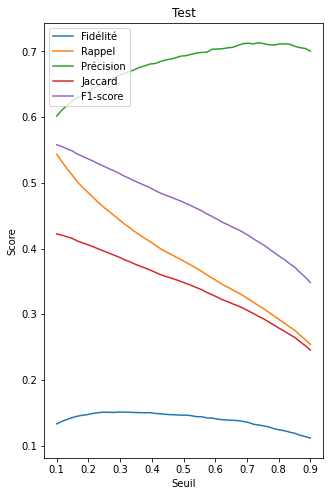

In [18]:
# Différents scores en fonction du seuil de validation de tag
rangeX = np.linspace(0.1,0.9,50)
plt.figure(figsize=(5,8))
for score, kwargs, title in zip(
    [metrics.accuracy_score, metrics.recall_score, metrics.precision_score, metrics.jaccard_score, metrics.f1_score], 
    [{},{'average':'weighted'},{'average':'weighted'},{'average':'weighted'},{'average':'weighted'}],
    ['Fidélité','Rappel','Précision','Jaccard','F1-score']):
    
    scores_train, scores_test = [], []
    for threshold in rangeX:
        scores_test.append(score(Y_test, tmp4 > threshold, **kwargs))
    plt.plot(rangeX, scores_test, label=title)
    
plt.title('Test')
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.legend()
plt.show()

In [19]:
threshold = 0.25
Y_pred_train = tmp3 > threshold
Y_pred_test = tmp4 > threshold

In [20]:
xtf_df = df_scores()
xtf_df

,Accuracy,Recall,Precision,F1 score,Jaccard
Train,0.448192,0.736448,0.909082,0.80243,0.687052
Test,0.150397,0.462238,0.652785,0.52501,0.395899


In [21]:
!zip -r XR-Transformer.zip XR-Transformer

  adding: XR-Transformer/ (stored 0%)
  adding: XR-Transformer/concat_model/ (stored 0%)
  adding: XR-Transformer/concat_model/param.json (deflated 6%)
  adding: XR-Transformer/concat_model/ranker/ (stored 0%)
  adding: XR-Transformer/concat_model/ranker/0.model/ (stored 0%)
  adding: XR-Transformer/concat_model/ranker/0.model/W.npz (deflated 38%)
  adding: XR-Transformer/concat_model/ranker/0.model/param.json (deflated 41%)
  adding: XR-Transformer/concat_model/ranker/0.model/C.npz (deflated 73%)
  adding: XR-Transformer/concat_model/ranker/param.json (deflated 28%)
  adding: XR-Transformer/concat_model/ranker/1.model/ (stored 0%)
  adding: XR-Transformer/concat_model/ranker/1.model/W.npz (deflated 35%)
  adding: XR-Transformer/concat_model/ranker/1.model/param.json (deflated 41%)
  adding: XR-Transformer/concat_model/ranker/1.model/C.npz (deflated 79%)
  adding: XR-Transformer/param.json (deflated 22%)
  adding: XR-Transformer/text_encoder/ (stored 0%)
  adding: XR-Transformer/text_e

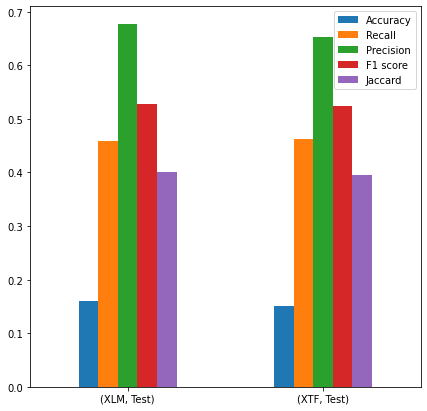

In [22]:
pd.concat([xlm_df, xtf_df], keys=['XLM','XTF']).loc[:,'Test',:].plot.bar(figsize=(7,7), rot=0);

## Examples

In [23]:
for i in range(5):
    print(i, 'True', tfidfY.inverse_transform(Y_test[i])[0])
    print(i, 'XRLi', tfidfY.inverse_transform((tmp2 > 0.25)[i])[0])
    print(i, 'XRtr', tfidfY.inverse_transform((tmp4 > 0.25)[i])[0])

0 True ['assembly' 'x86']
0 XRLi ['assembly']
0 XRtr ['assembly']
1 True ['exception' 'handling' 'net' 'services' 'vb' 'web']
1 XRLi ['exception' 'handling']
1 XRtr ['exception' 'handling' 'net']
2 True ['firefox']
2 XRLi ['firefox' 'macos']
2 XRtr ['firefox' 'macos']
3 True ['command' 'line' 'linux']
3 XRLi ['linux']
3 XRtr ['command' 'linux']
4 True ['null' 'overloading']
4 XRLi ['methods' 'overloading']
4 XRtr ['methods' 'overloading']
